In [1]:
import qckt
from qckt.backend import *
import qckt.noisemodel as ns

# Getting started

## create a simple bell-state circuit

In [2]:
cnotckt = qckt.QCkt(2, 2)

cnotckt.H(0)
cnotckt.CX(0,1)
cnotckt.M([0,1],[0,1])

cnotckt.draw()

q000 -[H]-[.]-[M]-----
           |   |      
q001 -----[X]--|--[M]-
               |   |  
creg ==========v===v==
                      


### use NoiseModel mechanism to add noise after each gate moment

In [3]:
noise_model = ns.NoiseModel(kraus_opseq_allgates=ns.bit_flip(0.1))
cnotckt.add_noise_model(noise_model=noise_model)
cnotckt.draw()

q000 -[H]-[H:BF(0.10)]-[.]-[CX:BF(0.10)]-[M]-----
                        |                 |      
q001 ------------------[X]-[CX:BF(0.10)]--|--[M]-
                                          |   |  
creg =====================================v===v==
                                                 


## running the circuit

### lets see what all backend engines we have available

In [4]:
qsimSvc().listInstances()

['qsim-eng', 'qsim-deb', 'nisqsim-eng', 'nisqsim-deb']

### create a job, and run it on backend that supports noise simulation
go ahead and also try running it on a backend that does not support noise simulation (the noise aspects will be ignored)

In [5]:
job = qckt.Job(cnotckt, shots=1000)
bk = qsimSvc().getInstance('nisqsim-eng')
bk.runjob(job)

### get and present the results

READ OUT STATE VECTOR: 
Density matrix DIAGONAL
11  1.00000000+0.00000000j

READ OUT CREGISTER: 00


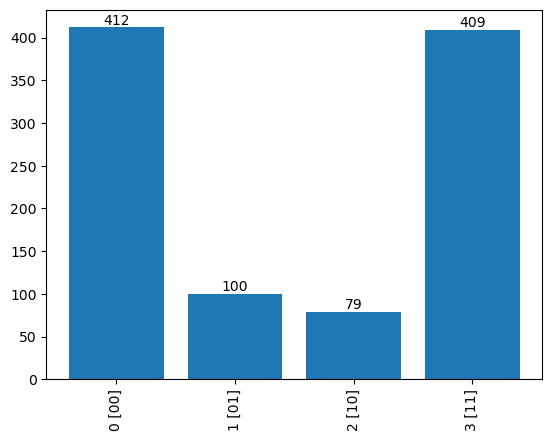

[412, 100, 79, 409]

In [6]:
print("READ OUT STATE VECTOR: ")
print(job.get_svec())
print("READ OUT CREGISTER: ", end="")
print( job.get_creg()[0])
job.plot_counts()

### Lets finally see the execution stats

In [7]:
job.print_runstats()

Total Ops  :     3      operations
Total Time :     0.0012 sec
Per Operation:
    H           0.0004 sec     1 times 0.0004 avg
    CX          0.0006 sec     1 times 0.0006 avg
    MEASURE     0.0002 sec     1 times 0.0002 avg


# More on NoiseModel

## `NoiseModel` class
`NoiseModel` has three fields
* `kraus_opseq_init` - can be `KrausOperator` or `KrausOperatorSequence` or `None` (default)
* `kraus_opseq_allgates` - can be `KrausOperator` or `KrausOperatorSequence` or `None` (default)
* `kraus_opseq_qubits` - can be `KrausOperatorApplierSequense` or `None` (default)

First, about `KrausOperator`, `KrausOperatorSequence`, `KrausOperatorApplierSequence`
* `KrausOperator` - is a representation of a kraus operator. Includes three fields
    * a sequence of $(k_i,p_i)$, to enable computing of $\sum_i(p_i k_i \rho k_i^\dagger)$
    * `name` for that operator (e.g., 'PF(0.10)' for a kraus operator bit-flip with $p_i = 0.1$)
    * `nqubits`, the number of qubits this kraus operator acts on.
* `KrausOperatorSequence` - often a sequence of `KrauseOperator`s are applied together. For that reason `KrausOperatorSequence` is used. It simply stores a sequence (ordered list) of `KrausOperator`s. It also has a `name` field to represent the list of `KrausOperator`s (e.g., 'PF(0.10),BF(0.05)')
* `KrausOperatorApplierSequence` - specification of applying a kraus operator onto certain qubits is refered to as `applier`. E.g., `(BF(0.05), [0,1,2])` specifies applyting bit-flip with probability of 0.05 to qubits 0, 1 and 2. Again, in general there can be a need to have a sequence of `appliers`, hence the `KrausOperatorApplierSequence`. As  common thread, this also has a `name` field for the entire applier sequence.

Back to `NoiseModel`.
* `kraus_opseq_init` specifies a `KrausOperator`, or a `KrauseOperatorSequence` to be applied to *all* qubits at the initialization of the quantum computer. The kraus operators specified in this *must* be 1-qubit operators.
* `kraus_opseq_allgates` specifies a `KrausOperator`, or a `KrauseOperatorSequence` to be applied immediately after *each* gate in the circuit. The kraus operators specified in this *must* be 1-qubit operators.
* `kraus_opseq_qubits` specifies a `KrausOperatorApplierSequence` to be applied immediately after *each* gate in the circuit. The qubits to which the operator is actually applied is the intersection of the set of qubits that gate is applied to and the qubits in individual applier entries. The kraus operators specified in this *must* be 1-qubit operators.

## 1-qubit, 2-qubit (and potentially, multi-qubit) kraus operators
kraus operators can be 1-qubit, 2-qubit, or in general, multi-qubit operators. At the time of application of the operator the size of the operator is checked -
* if the operator is 1-qubit sized, it gets *broadcast* to all the qubits it is being applied to. That is, it is individually applied to each of the qubits in the applier.
* if not 1-qubit, then the number of qubits *must* match the size of the operator, else an error occurs and the run is terminated.

# Applying a more geenral NoiseModel to the circuit

In [8]:
# same simple circuit
cnotckt = qckt.QCkt(2, 2)
cnotckt.H(0)
cnotckt.CX(0,1)
cnotckt.M([0,1],[0,1])
cnotckt.draw()

q000 -[H]-[.]-[M]-----
           |   |      
q001 -----[X]--|--[M]-
               |   |  
creg ==========v===v==
                      


## apply all the three components of the NoiseModel

q000 -[INIT:GAD(0.10,0.05)]-[H]-[H:PD(0.10)]-[H:BF(0.10)]-[.]-[CX:PD(0.10)]-[CX:BF(0.10)]-[M]-----
                                                           |                               |      
q001 -[INIT:GAD(0.10,0.05)]-------------------------------[X]---------------[CX:BF(0.10)]--|--[M]-
                                                                                           |   |  
creg ======================================================================================v===v==
                                                                                                  


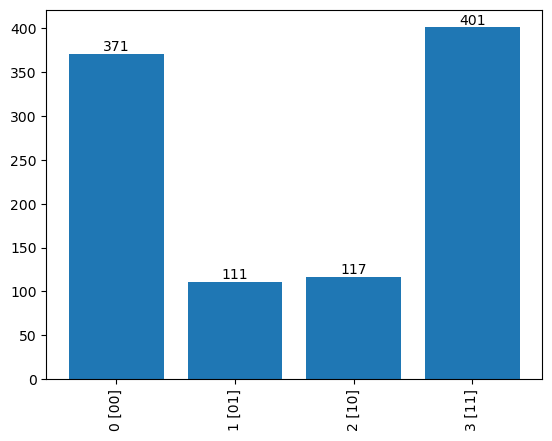

[371, 111, 117, 401]

In [9]:
noise_model = ns.NoiseModel(
    kraus_opseq_init=ns.generalized_amplitude_damping(probability=0.1,gamma=0.05),
    kraus_opseq_allgates=ns.bit_flip(0.1),
    kraus_opseq_qubits=ns.KrausOperatorApplierSequense(ns.phase_damping(gamma=0.1),[0]),
    )
cnotckt.add_noise_model(noise_model=noise_model)
cnotckt.draw()


job = qckt.Job(cnotckt, shots=1000)
bk = qsimSvc().getInstance('nisqsim-eng')
bk.runjob(job)
job.plot_counts()

## apply noise to all the gates of a type
In  addition to `NoiseModel`, another way to apply noise globally is to specify noise for individual gate types using `.add_noise_to_all()`.

**Note: Global Noise speccification applies to the entire circuit**. As you will notice, the global noise specifications, `NoiseModel` as well as `.add_noise_to_all()`, are applied to the entire circuit irrespective of whether they are specified -- at the beginning, middle, or end of the circuit definition.

q000 -[H]-[H:BF(0.15)]-[.]------------------[M]-----
                        |                    |      
q001 ------------------[X]-[H]-[H:BF(0.15)]--|--[M]-
                                             |   |  
creg ========================================v===v==
                                                    


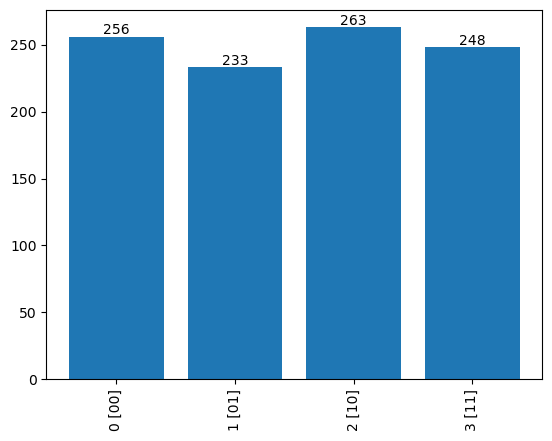

[256, 233, 263, 248]

In [16]:
# same simple circuit
cnotckt = qckt.QCkt(2, 2)
cnotckt.H(0)
cnotckt.CX(0,1)
cnotckt.H(1)
cnotckt.M([0,1],[0,1])

# apply noise to all H gates
cnotckt.H.add_noise_to_all(ns.bit_flip(0.15))
cnotckt.draw()


job = qckt.Job(cnotckt, shots=1000)
bk = qsimSvc().getInstance('nisqsim-eng')
bk.runjob(job)
job.plot_counts()